# Wave Packets

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.animation

In [3]:
from IPython.display import HTML

A particle with total energy $E$ in a region of constant potential $V_0$ has a wave number
$$
k = \pm \frac{2m}{\hbar^2}(E - V_0)
$$
and dispersion relation
$$
\omega(k) = \frac{E(k)}{\hbar} = \frac{\hbar k^2}{2m} + \frac{V_0}{\hbar}
$$
leading to phase and group velocities
$$
v_p(k) = \frac{\omega(k)}{k} = \frac{\hbar k}{2 m} + \frac{V_0}{\hbar k} \quad, \quad
v_g(k) = \frac{d\omega}{dk}(k) = \frac{\hbar k}{m} \; .
$$

Consider an initial state at $t=0$ that is a normalized Gaussian wavepacket
$$
\Psi(x,0) = \pi^{-1/4} \sigma_x^{-1/2} e^{i k_0 x}\,
\exp\left(-\frac{1}{2} \frac{x^2}{\sigma_x^2}\right)
$$
with group velocity $v_g = \hbar k_0 / m$.

We can expand this state's time evolution in plane waves as
$$
\Psi(x,t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{+\infty} c(k)
\exp\left[ i k(x - v_p(k) t)\right] dk
$$
with coefficients
$$
c(k) = \frac{1}{\sqrt{2\pi}}\,\int_{-\infty}^{+\infty} \Psi(x,0)\, e^{-i k x} dx
= \pi^{-1/4} \sigma_x^{1/2}\, \exp\left( -\frac{1}{2} (k - k_0)^2 \sigma_x^2\right) \; .
$$

Measure $V_0$ and $m$ in units of $\hbar$, then
$$
\text{Re}\Psi(x,t) = \pi^{-1/4} \sigma_x^{1/2}\, 
\int_{-\infty}^{+\infty} \exp\left[
-\frac{1}{2} (k - k_0)^2 \sigma_x^2\right] \cos\left[k x - \left(\frac{k^2}{2m} + V_0\right) t \right] dk \; .
$$

In [4]:
def solve(k0=10., sigmax=0.25, V0=0., mass=1., tmax=0.25, nwave=15, nx=500, nt=10):
    """
    Solve for the evolution of a 1D Gaussian wave packet.
    
    Parameters
    ----------
    k0 : float
        central wavenumber
    sigmax : float
        initial wave packet sigma
    V0 : float
        constant potential divided by hbar
    mass : float
        particle mass divided by hbar
    tmax : float
        Amount of time to simulate on a uniform grid.
    nwave : int
        Wave packet is approximated by 2*nwave+1 plane waves centered on k0.
    nx : int
        Number of grid points to use in x.
    nt : int
        Number of grid points to use in t.
    """
    t = np.linspace(0, tmax, nt).reshape(-1, 1)

    # Calculate the group velocity at k0.
    vgroup0 = k0 / mass
    
    # Calculate the distance traveled by the wave packet.
    dist = np.abs(vgroup0) * tmax
    
    # Calculate the spreading of the wave packet.
    spread = np.sqrt((sigmax ** 4 + (t / mass) ** 2) / sigmax ** 2)
    
    # Calculate an x-range that keeps the packet visible during tmax.
    nsigmas = 1.5
    tails = nsigmas * (spread[0] + spread[-1])
    xrange = max(tails + dist, 2 * tails)
    x0 = nsigmas * spread[0] + 0.5 * (xrange - tails) - 0.5 * vgroup0 * tmax - 0.5 * xrange
    x = np.linspace(-0.5 * xrange, 0.5 * xrange, nx) - x0

    # Build grid of k values to use, centered on k0.
    nsigmas = 2.0
    sigmak = 1. / sigmax
    k = k0 + sigmak * np.linspace(-nsigmas, +nsigmas, 2 * nwave + 1).reshape(-1, 1, 1)
    
    # Calculate coefficients c(k).
    ck = np.exp(-0.5 * (k - k0) ** 2 * sigmax ** 2)
    
    # Calculate omega(k)
    omega = k ** 2 / (2 * mass) + V0
    
    # Calculate the (un-normalized) evolution of each wavenumber.
    psi = ck * np.cos(k * x - omega * t)

    # Calculate the (x,y) coordinates of a tracer for each wavenumber.
    xtrace = np.zeros((nt, 2 * nwave + 1))
    nz = k != 0
    xtrace[:, nz.ravel()] = ((k[nz] / (2 * mass) + V0 / k[nz]) * t)
    ytrace = ck.reshape(-1)
    
    # Calculate the motion of the center of the wave packet.
    xcenter = vgroup0 * t
    
    return x, psi, xtrace, ytrace, xcenter

Build an animation using the solver above:

In [5]:
def animate(k0=10., sigmax=0.25, V0=0., mass=1., nt=30, save=None, height=250, width=400):
    
    x, psi, xt, yt, xc = solve(k0, sigmax, V0, mass, nt=nt)
    nw, nt, nx = psi.shape
    nwave = (nw - 1) // 2
    psi_sum = np.sum(psi, axis=0)

    ymax = 1.02 * np.max(np.abs(psi_sum))
    dy = 0.95 * ymax * np.arange(-nwave, nwave + 1) / nwave
    assert len(dy) == nw
    
    artists = []
    dpi = 100.
    dot = 0.006 * height
    figure = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi, frameon=False)
    ax = figure.add_axes([0, 0, 1, 1])
    plt.axis('off')
    for i in range(2 * nwave + 1):
        artists += ax.plot(x, psi[i, 0] + dy[i], lw=2 * dot, c='b', alpha=0.2)
    artists.append(ax.axvline(xc[0], c='r', ls='-', lw=dot, alpha=0.4))
    artists += ax.plot(xt[0], yt + dy, 'b.', ms=2.5 * dot, alpha=0.4, lw=0)
    artists += ax.plot(x, psi_sum[0], 'r-', lw=2.5 * dot, alpha=0.5)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(-ymax, +ymax)
    
    def init():
        return artists
    
    def update(j):
        for i in range(2 * nwave + 1):
            artists[i].set_ydata(psi[i, j] + dy[i])
        artists[-3].set_xdata([xc[j], xc[j]])
        artists[-2].set_xdata(xt[j])
        artists[-1].set_ydata(psi_sum[j])
        return artists
        
    animation = matplotlib.animation.FuncAnimation(
        figure, update, init_func=init, frames=nt, repeat=True, blit=True)
    if save:
        meta = dict(
            title='Gaussian quantum wavepacket superposition in 1D',
            artist='David Kirkby <dkirkby@uci.edu>',
            comment='https://dkirkby.github.io/quantum-demo/',
            copyright='Copyright (c) 2018 David Kirkby')
        engine = 'imagemagick' if save.endswith('.gif') else 'ffmpeg'
        writer = matplotlib.animation.writers[engine](fps=30, metadata=meta)
        animation.save(save, writer=writer)
        
    return animation

Simulate with different values of the constant potential:
$$
\begin{aligned}
V_0 &= -50 \quad &\Rightarrow \quad v_p(k_0) &= 0 \\
V_0 &= 0 \quad &\Rightarrow \quad v_p(k_0) &= v_g(k_0) / 2 \\
V_0 &= +50 \quad &\Rightarrow \quad v_p(k_0) &= v_g(k_0) \\
\end{aligned}
$$

A GIF animation produces a larger file than MP4, even at this lower resolution.

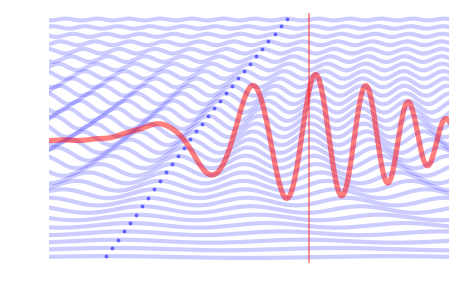

In [6]:
animate(V0=0, nt=300, save='wavepacket1.gif');

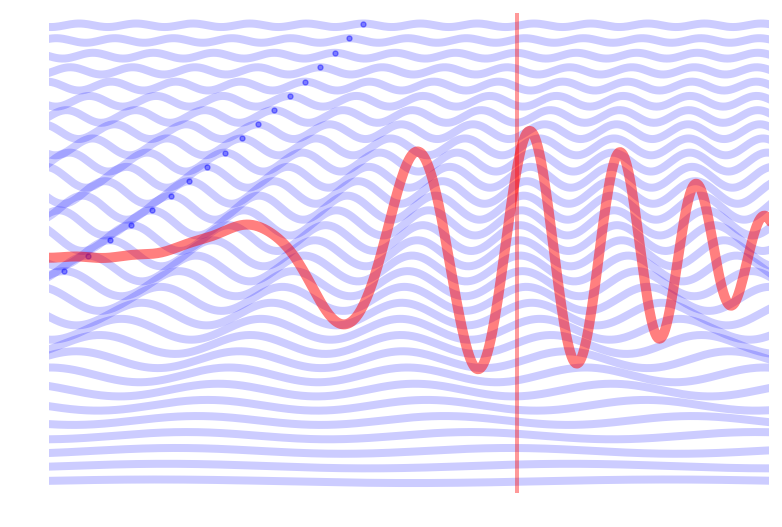

In [7]:
animate(V0=-50, nt=300, height=480, width=720, save='wavepacket0.mp4');

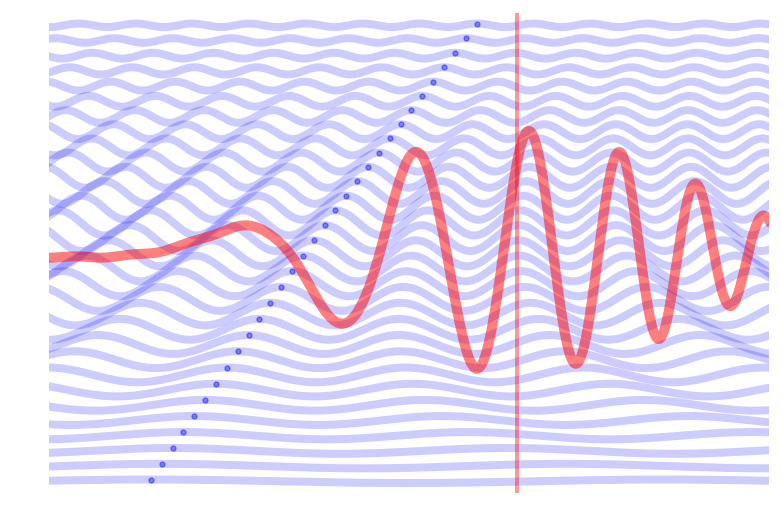

In [8]:
animate(V0=0, nt=300, height=480, width=720, save='wavepacket1.mp4');

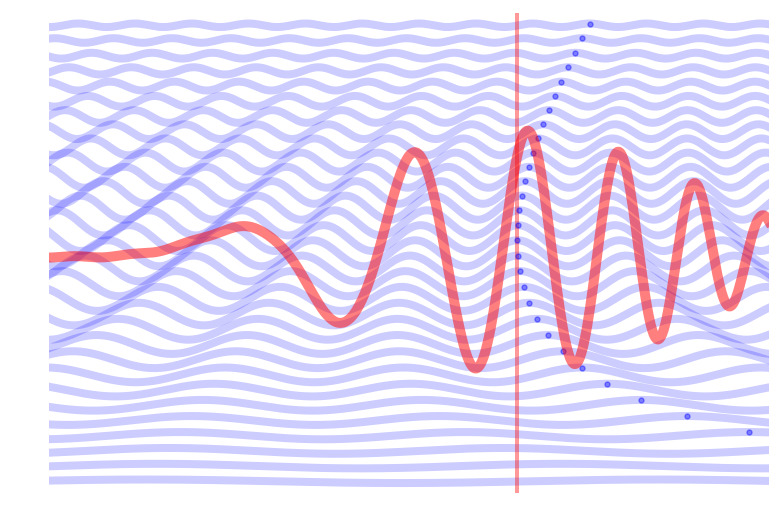

In [9]:
animate(V0=50, nt=300, height=480, width=720, save='wavepacket2.mp4');

Uncomment and run the line below to display the animation inline:

In [10]:
#HTML(animate().to_html5_video())

Convert video to the open-source Theora format using, e.g.
```
ffmpeg -i wavepacket0.mp4 -codec:v libtheora -qscale:v 7 wavepacket0.ogv
```